## Cargar las librerias necesarias.

In [ ]:
# Importar librerías necesarias
import numpy as np
import keras
import matplotlib.pyplot as plt
import keras.utils as np_utils
# Importar el optimizador a usar
from keras.optimizers import SGD
# Importtar el conjunto de datos
from keras.datasets import cifar100
# Importar modelos y capas que se van a usar
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

## Declarar variables 

In [1]:
# Number of samples processed before the model is updated.
batch_size = 128
# Ammount of classes
num_classes = 25
# Number of times that the learning algorithm will work through the entire training dataset.
epochs = 50
# input image dimensions
img_rows, img_cols = 32, 32
# input shape
input_shape = (img_rows, img_cols, 3)

Using TensorFlow backend.


## Cargar y modificar el conjunto de datos.

Devuelve.
+ Las imágenes de entrenamiento.
+ Las clases de las imagenes de enternamiento.
+ Las imágenes del conjunto de test
+ Las clases del conjunto de test.


In [15]:
def cargarImagenes():
    # Carga las imagenes
    (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # Las transforma a flotantes y normaliza.
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    # Trataremos solo con 25 clases de todas las que tiene el modelo
    train_idx = np.isin(y_train, np.arange(25))
    train_idx = np.reshape(train_idx, -1)
    x_train = x_train[train_idx]
    y_train = y_train[train_idx]
    test_idx = np.isin(y_test, np.arange(25))
    test_idx = np.reshape(test_idx, -1)
    x_test = x_test[test_idx]
    y_test = y_test[test_idx]
    
    # Pasamos las variables a categoricas
    y_train = np_utils.to_categorical(y_train, 25)
    y_test = np_utils.to_categorical(y_test, 25)
    
    return x_train, y_train, x_test, y_test

## Obtener el accuracy en el conjunto de test

Esta función devuelve el accuracy de un modelo, definido como el porcentaje de etiquetas bien predichas frente al total de etiquetas. 

Parámetros:
+ Vector de etiquetas verdaderas
+ Vector de etiquedas predichas. 

Ambos en el formato de keras (matrices donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase a la que pertenece y 0 en las demás).

In [3]:
def calcularAccuracy(labels, preds):
    labels = np.argmax(labels, axis = 1)
    preds = np.argmas(preds, axis = 1)
    
    return sum(labels==preds)/len(labels)

## Función pintar la pérdida y el accuracy en train y validación.

Esta función pinta dos gráficas
+ La evolución de la función de pérdida en el conjunto de train y en el de validación.
+ La evolución del accuracy en el conjunto de train y el de validación.

Parmámetros
+ ```hist```: Historial del entrenamiento del modelo

In [4]:
def mostrarEvolucion(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.show()
    
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training accuracy', 'Validation accuracy'])

## Definición del modelo BaseNet

In [ ]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5,5), 
                activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

Resumen del modelo.

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                20050     
_________________________________________________________________
dense_2 (Dense)              (None, 25)               

## Definicion del optimizador y compilacion del modelo

Configura el modelo para el entrenamiento. Parámetros:
+ ```optimizer:``` Optimizador a utilizar.
+ ```loss:``` Función de pérdida.
+ ```metrics:``` Métrica a utilizar durante el entrenamiento y las predicciones.

In [6]:
model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = SGD(lr = 0.01, decay = 1e-6, momentum=0.9, nesterov=True),
              metrics = ['accuracy'])

Una vez tenemos el modelo base, y antes de entrenar, vamos a guardar los pesos aleatorios con los que empieza la red, para poder reestablecerlos después y comparar resultados entre no usar mejoras y sí usarlas.

In [7]:
weights = model.get_weights()

## Entrenamiento del modelo

Trains the model for a fixed number of epochs (iterations on a dataset).

In [8]:
x_train, y_train, x_test, y_test = cargarImagenes()
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 12500 samples, validate on 2500 samples
Epoch 1/50
12500/12500 [==============================] - 5s 364us/step - loss: 3.1758 - accuracy: 0.0700 - val_loss: 3.0427 - val_accuracy: 0.1304
Epoch 2/50
12500/12500 [==============================] - 4s 332us/step - loss: 2.8649 - accuracy: 0.1774 - val_loss: 2.6771 - val_accuracy: 0.2148
Epoch 3/50
12500/12500 [==============================] - 5s 372us/step - loss: 2.5254 - accuracy: 0.2662 - val_loss: 2.3962 - val_accuracy: 0.3068
Epoch 4/50
12500/12500 [==============================] - 5s 377us/step - loss: 2.3305 - accuracy: 0.3233 - val_loss: 2.3288 - val_accuracy: 0.3192
Epoch 5/50
12500/12500 [==============================] - 4s 313us/step - loss: 2.2028 - accuracy: 0.3571 - val_loss: 2.2361 - val_accuracy: 0.3444
Epoch 6/50
12500/12500 [==============================] - 3s 268us/step - loss: 2.1037 - accuracy: 0.3838 - val_loss: 2.1891 - val_accuracy: 0.3768
Epoch 7/50
12500/12500 [==============================] - 4s 28

## Predicciones.

Test loss: 2.61083948097229
Test accuracy: 0.4343999922275543


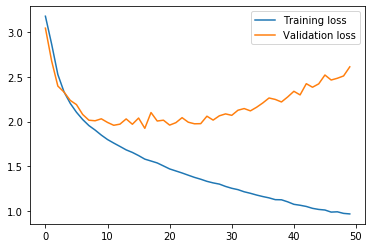

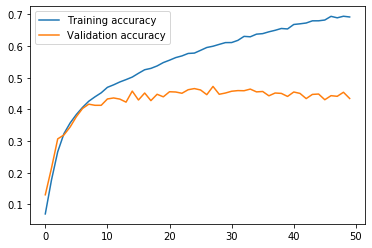

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
mostrarEvolucion(history)

## Mejora del modelo

Tanto la normalización de los datos como el data augmentation debe hacerse con la clase ImageDataGenerator.
Se recomienda ir entrenando con cada paso para comprobar en qué grado mejora cada uno de ellos.